# 🔄 Comparación: Encoder-Only vs Decoder-Only

**Tarea 2 - Proyecto Final de Doctorado en IA/NLP**

Este notebook implementa y compara:
1. **BERT (Encoder-Only)**: Masked Language Modeling (MLM)
2. **GPT (Decoder-Only)**: Autoregressive Language Modeling

Objetivo: Entender por qué los modelos decoder-only son mejores para generación de texto.

---

## 1. Setup

In [ ]:
# Cargar datos desde Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/MiniGPT_Doctoral'

# Crear carpetas locales
os.makedirs('data/processed', exist_ok=True)
os.makedirs('tokenizer', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Copiar archivos necesarios
!cp {project_path}/data/processed/*.json data/processed/
!cp {project_path}/tokenizer/bpe_tokenizer.json tokenizer/
!cp -r {project_path}/tokenizer/hf_tokenizer tokenizer/

print("✅ Archivos cargados desde Google Drive")

Mounted at /content/drive
✅ Archivos cargados desde Google Drive


In [ ]:
!pip install torch transformers tokenizers matplotlib seaborn -q
print("✅ Dependencias instaladas")

✅ Dependencias instaladas


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import PreTrainedTokenizerFast
import numpy as np

# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Dispositivo: {device}")

# Cargar tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained('tokenizer/hf_tokenizer')
VOCAB_SIZE = tokenizer.vocab_size
print(f"📚 Vocabulario: {VOCAB_SIZE} tokens")

🖥️ Dispositivo: cpu
📚 Vocabulario: 32000 tokens


## 2. Fundamentos Teóricos

### 2.1 Arquitectura Transformer Original

El paper "Attention Is All You Need" (Vaswani et al., 2017) introdujo el Transformer con:
- **Encoder**: Procesa la entrada completa con atención bidireccional
- **Decoder**: Genera salida de forma autoregresiva con atención causal

### 2.2 Variantes Modernas

| Arquitectura | Modelo | Tarea Principal | Atención |
|--------------|--------|-----------------|----------|
| Encoder-Only | BERT | Comprensión (MLM, clasificación) | Bidireccional |
| Decoder-Only | GPT | Generación de texto | Causal (unidireccional) |
| Encoder-Decoder | T5, BART | Seq2Seq (traducción, resumen) | Mixta |

## 3. Implementación de Componentes Comunes

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Codificación posicional sinusoidal del paper original.
    Añade información de posición a los embeddings.
    """
    def __init__(self, d_model, max_seq_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Crear matriz de posiciones
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_seq_len, d_model]

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Atención multi-cabeza.
    Puede ser bidireccional (encoder) o causal (decoder).
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Proyecciones lineales y reshape para multi-head
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Aplicar atención a valores
        context = torch.matmul(attn_weights, V)

        # Concatenar cabezas y proyección final
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)

        return output, attn_weights

In [ ]:
class FeedForward(nn.Module):
    """
    Red feed-forward posicional.
    FFN(x) = max(0, xW1 + b1)W2 + b2
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

## 4. Modelo Encoder-Only (Estilo BERT)

### Características:
- **Atención bidireccional**: Cada token puede ver todos los demás tokens
- **Masked Language Modeling (MLM)**: Predice tokens enmascarados
- **No generativo**: No puede generar texto secuencialmente

In [ ]:
class EncoderBlock(nn.Module):
    """Bloque encoder con atención bidireccional"""
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention con conexión residual
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward con conexión residual
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x, attn_weights


class EncoderOnlyModel(nn.Module):
    """
    Modelo Encoder-Only (estilo BERT).
    Usa atención BIDIRECCIONAL - cada token ve todos los demás.
    Diseñado para tareas de comprensión (MLM, clasificación).
    """
    def __init__(self, vocab_size, d_model=256, num_heads=4, num_layers=4, d_ff=512,
                 max_seq_len=512, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len, dropout)

        self.encoder_layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(d_model)

        # Cabeza para MLM (predecir tokens enmascarados)
        self.mlm_head = nn.Linear(d_model, vocab_size)

    def forward(self, input_ids, attention_mask=None):
        # Embeddings + positional encoding
        x = self.embedding(input_ids) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)

        # Máscara de padding (si se proporciona)
        if attention_mask is not None:
            # [batch, seq_len] -> [batch, 1, 1, seq_len]
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Pasar por capas del encoder (ATENCIÓN BIDIRECCIONAL)
        all_attn_weights = []
        for layer in self.encoder_layers:
            x, attn_weights = layer(x, attention_mask)
            all_attn_weights.append(attn_weights)

        x = self.norm(x)

        # Predicción MLM
        logits = self.mlm_head(x)

        return logits, all_attn_weights

print("✅ EncoderOnlyModel (BERT-style) definido")

✅ EncoderOnlyModel (BERT-style) definido


## 5. Modelo Decoder-Only (Estilo GPT)

### Características:
- **Atención causal**: Cada token solo puede ver tokens anteriores
- **Autoregresivo**: Genera un token a la vez, condicionado en los anteriores
- **Generativo**: Diseñado para generar texto

In [ ]:
class DecoderBlock(nn.Module):
    """Bloque decoder con atención CAUSAL"""
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, causal_mask):
        # Self-attention CAUSAL con conexión residual
        attn_output, attn_weights = self.self_attn(x, x, x, causal_mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward con conexión residual
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x, attn_weights


class DecoderOnlyModel(nn.Module):
    """
    Modelo Decoder-Only (estilo GPT).
    Usa atención CAUSAL - cada token solo ve tokens anteriores.
    Diseñado para generación de texto autoregresiva.
    """
    def __init__(self, vocab_size, d_model=256, num_heads=4, num_layers=4, d_ff=512,
                 max_seq_len=512, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len, dropout)

        self.decoder_layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(d_model)

        # Cabeza para LM (predecir siguiente token)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def _create_causal_mask(self, seq_len, device):
        """
        Crea máscara causal triangular inferior.
        Permite que cada posición solo atienda a posiciones anteriores.
        """
        mask = torch.tril(torch.ones(seq_len, seq_len, device=device)).bool()
        return mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, seq_len]

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape

        # Embeddings + positional encoding
        x = self.embedding(input_ids) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)

        # Crear máscara causal
        causal_mask = self._create_causal_mask(seq_len, input_ids.device)

        # Pasar por capas del decoder (ATENCIÓN CAUSAL)
        all_attn_weights = []
        for layer in self.decoder_layers:
            x, attn_weights = layer(x, causal_mask)
            all_attn_weights.append(attn_weights)

        x = self.norm(x)

        # Predicción del siguiente token
        logits = self.lm_head(x)

        return logits, all_attn_weights

    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens=50, temperature=1.0, top_p=0.9):
        """
        Genera texto de forma autoregresiva.
        Esta capacidad NO existe en modelos encoder-only.
        """
        self.eval()
        generated = input_ids.clone()

        for _ in range(max_new_tokens):
            # Truncar si excede max_seq_len
            if generated.size(1) >= self.max_seq_len:
                context = generated[:, -self.max_seq_len:]
            else:
                context = generated

            # Forward pass
            logits, _ = self.forward(context)

            # Obtener logits del último token
            next_token_logits = logits[:, -1, :] / temperature

            # Top-p sampling
            sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = 0

            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            next_token_logits[indices_to_remove] = float('-inf')

            # Samplear
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            generated = torch.cat([generated, next_token], dim=1)

            # Parar si es EOS
            if next_token.item() == tokenizer.eos_token_id:
                break

        return generated

print("✅ DecoderOnlyModel (GPT-style) definido")

✅ DecoderOnlyModel (GPT-style) definido


## 6. Visualización de Patrones de Atención

In [ ]:
# Crear instancias de ambos modelos
config = {
    'vocab_size': VOCAB_SIZE,
    'd_model': 128,
    'num_heads': 4,
    'num_layers': 2,
    'd_ff': 256,
    'max_seq_len': 128,
    'dropout': 0.1
}

encoder_model = EncoderOnlyModel(**config).to(device)
decoder_model = DecoderOnlyModel(**config).to(device)

print(f"📊 Encoder-Only params: {sum(p.numel() for p in encoder_model.parameters()):,}")
print(f"📊 Decoder-Only params: {sum(p.numel() for p in decoder_model.parameters()):,}")

📊 Encoder-Only params: 8,489,216
📊 Decoder-Only params: 8,489,216


In [ ]:
# Texto de ejemplo
test_text = "El aprendizaje profundo es fascinante"
tokens = tokenizer.encode(test_text, return_tensors='pt').to(device)
token_strs = tokenizer.convert_ids_to_tokens(tokens[0].tolist())

print(f"Texto: {test_text}")
print(f"Tokens: {token_strs}")
print(f"IDs: {tokens[0].tolist()}")

Texto: El aprendizaje profundo es fascinante
Tokens: ['El', 'Ġaprendizaje', 'Ġprofundo', 'Ġes', 'Ġfascinante']
IDs: [1939, 865, 2300, 225, 11409]


In [ ]:
# Obtener patrones de atención
encoder_model.eval()
decoder_model.eval()

with torch.no_grad():
    _, encoder_attn = encoder_model(tokens)
    _, decoder_attn = decoder_model(tokens)

print("✅ Patrones de atención calculados")

✅ Patrones de atención calculados


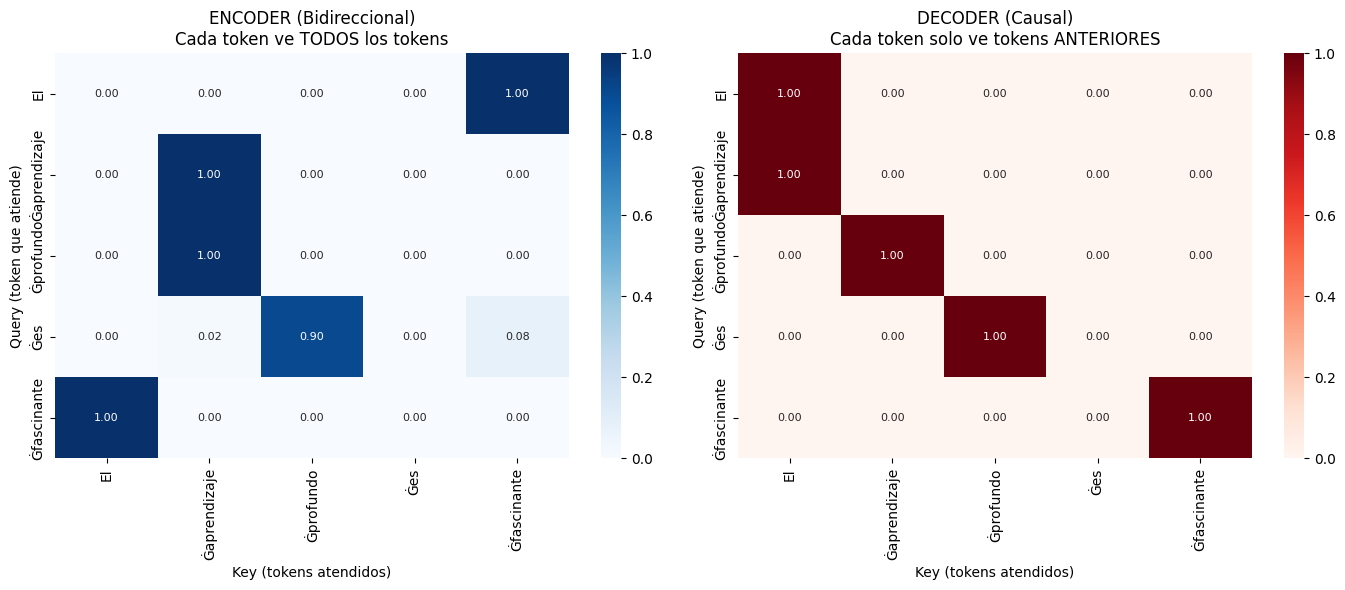


🔍 ANÁLISIS:
   ENCODER: Matriz completa - atención bidireccional
   DECODER: Matriz triangular inferior - atención causal
   La diagonal superior del decoder es 0 (tokens futuros enmascarados)


In [ ]:
def plot_attention_comparison(encoder_attn, decoder_attn, tokens, layer=0, head=0):
    """
    Compara patrones de atención entre encoder (bidireccional) y decoder (causal).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Atención del Encoder (BIDIRECCIONAL)
    enc_attn = encoder_attn[layer][0, head].cpu().numpy()
    sns.heatmap(enc_attn, ax=axes[0], cmap='Blues',
                xticklabels=tokens, yticklabels=tokens,
                annot=True, fmt='.2f', annot_kws={'size': 8})
    axes[0].set_title('ENCODER (Bidireccional)\nCada token ve TODOS los tokens', fontsize=12)
    axes[0].set_xlabel('Key (tokens atendidos)')
    axes[0].set_ylabel('Query (token que atiende)')

    # Atención del Decoder (CAUSAL)
    dec_attn = decoder_attn[layer][0, head].cpu().numpy()
    sns.heatmap(dec_attn, ax=axes[1], cmap='Reds',
                xticklabels=tokens, yticklabels=tokens,
                annot=True, fmt='.2f', annot_kws={'size': 8})
    axes[1].set_title('DECODER (Causal)\nCada token solo ve tokens ANTERIORES', fontsize=12)
    axes[1].set_xlabel('Key (tokens atendidos)')
    axes[1].set_ylabel('Query (token que atiende)')

    plt.tight_layout()
    plt.savefig('attention_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n🔍 ANÁLISIS:")
    print("   ENCODER: Matriz completa - atención bidireccional")
    print("   DECODER: Matriz triangular inferior - atención causal")
    print("   La diagonal superior del decoder es 0 (tokens futuros enmascarados)")

plot_attention_comparison(encoder_attn, decoder_attn, token_strs)

## 7. Demostración: ¿Por qué el Encoder NO puede generar texto?

In [ ]:
print("="*70)
print("🔴 ¿POR QUÉ BERT (ENCODER-ONLY) NO PUEDE GENERAR TEXTO?")
print("="*70)

print("""
1. ATENCIÓN BIDIRECCIONAL:
   - En el encoder, cada token puede ver TODOS los demás tokens
   - Esto incluye tokens FUTUROS que aún no se han generado
   - Durante la generación, no existen tokens futuros para consultar

2. ENTRENAMIENTO MLM (Masked Language Modeling):
   - BERT se entrena para predecir tokens [MASK] en medio del texto
   - Usa contexto de AMBOS lados (izquierda y derecha)
   - No aprende a predecir el SIGUIENTE token secuencialmente

3. PROBLEMA DE INFERENCIA:
   - Para generar: "El gato _____"
   - Encoder necesita ver: "El gato [palabras futuras]"
   - ¡Pero las palabras futuras no existen todavía!

4. SOLUCIÓN: DECODER-ONLY (GPT)
   - Atención CAUSAL: solo ve tokens anteriores
   - Entrenamiento autoregresivo: predice el siguiente token
   - Puede generar un token a la vez de forma coherente
""")

🔴 ¿POR QUÉ BERT (ENCODER-ONLY) NO PUEDE GENERAR TEXTO?

1. ATENCIÓN BIDIRECCIONAL:
   - En el encoder, cada token puede ver TODOS los demás tokens
   - Esto incluye tokens FUTUROS que aún no se han generado
   - Durante la generación, no existen tokens futuros para consultar

2. ENTRENAMIENTO MLM (Masked Language Modeling):
   - BERT se entrena para predecir tokens [MASK] en medio del texto
   - Usa contexto de AMBOS lados (izquierda y derecha)
   - No aprende a predecir el SIGUIENTE token secuencialmente

3. PROBLEMA DE INFERENCIA:
   - Para generar: "El gato _____"
   - Encoder necesita ver: "El gato [palabras futuras]"
   - ¡Pero las palabras futuras no existen todavía!

4. SOLUCIÓN: DECODER-ONLY (GPT)
   - Atención CAUSAL: solo ve tokens anteriores
   - Entrenamiento autoregresivo: predice el siguiente token
   - Puede generar un token a la vez de forma coherente



In [ ]:
# Demostración práctica
print("\n" + "="*70)
print("🟢 DEMOSTRACIÓN DE GENERACIÓN CON DECODER-ONLY")
print("="*70)

prompt = "Instrucción: Explica qué es"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

print(f"\nPrompt: {prompt}")
print("\nGenerando texto...")

# Generar con el decoder
generated_ids = decoder_model.generate(input_ids, max_new_tokens=20, temperature=0.8)
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print(f"\nTexto generado: {generated_text}")
print("\n(Nota: El modelo no está entrenado, por lo que el texto no tiene sentido.")
print(" Lo importante es que PUEDE generar, a diferencia del encoder.)")


🟢 DEMOSTRACIÓN DE GENERACIÓN CON DECODER-ONLY

Prompt: Instrucción: Explica qué es

Generando texto...

Texto generado: Instrucción: Explica qué esanta leg interacciones dirigía visitantesEx plátanGre protocolo!".olatilidad fortuosaestos ing inmunológico ladró contribuye repercusiones administrativas

(Nota: El modelo no está entrenado, por lo que el texto no tiene sentido.
 Lo importante es que PUEDE generar, a diferencia del encoder.)


## 8. Tabla Comparativa Completa

In [ ]:
print("\n" + "="*80)
print("📊 TABLA COMPARATIVA: ENCODER-ONLY vs DECODER-ONLY")
print("="*80)

comparison_table = """
┌─────────────────────┬──────────────────────────┬──────────────────────────┐
│ Característica      │ ENCODER-ONLY (BERT)      │ DECODER-ONLY (GPT)       │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Tipo de atención    │ Bidireccional            │ Causal (unidireccional)  │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Contexto visible    │ Todos los tokens         │ Solo tokens anteriores   │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Tarea de entreno    │ MLM (Masked LM)          │ CLM (Causal LM)          │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Objetivo            │ Predecir tokens [MASK]   │ Predecir siguiente token │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Puede generar texto │ ❌ NO                    │ ✅ SÍ                    │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Mejor para          │ Clasificación, NER,      │ Generación de texto,     │
│                     │ Q&A extractivo           │ Chatbots, Código         │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Ejemplos            │ BERT, RoBERTa, ALBERT    │ GPT-2/3/4, LLaMA, Claude │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Máscara de atención │ Sin máscara (o solo pad) │ Triangular inferior      │
└─────────────────────┴──────────────────────────┴──────────────────────────┘
"""
print(comparison_table)


📊 TABLA COMPARATIVA: ENCODER-ONLY vs DECODER-ONLY

┌─────────────────────┬──────────────────────────┬──────────────────────────┐
│ Característica      │ ENCODER-ONLY (BERT)      │ DECODER-ONLY (GPT)       │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Tipo de atención    │ Bidireccional            │ Causal (unidireccional)  │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Contexto visible    │ Todos los tokens         │ Solo tokens anteriores   │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Tarea de entreno    │ MLM (Masked LM)          │ CLM (Causal LM)          │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Objetivo            │ Predecir tokens [MASK]   │ Predecir siguiente token │
├─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Puede generar texto │ ❌ NO                    │ ✅ SÍ                    │
├─────────────

## 9. Conclusiones y Justificación del Diseño

In [ ]:
print("\n" + "="*80)
print("📝 CONCLUSIONES PARA EL INFORME TÉCNICO")
print("="*80)

conclusions = """
JUSTIFICACIÓN DE USAR ARQUITECTURA DECODER-ONLY PARA MINIGPT:

1. OBJETIVO DEL PROYECTO:
   - Crear un modelo instructivo que responda preguntas y siga instrucciones
   - Esto requiere GENERACIÓN de texto, no solo comprensión

2. CAPACIDAD GENERATIVA:
   - Solo decoder-only puede generar texto de forma autoregresiva
   - La atención causal permite generar token por token coherentemente

3. ESTADO DEL ARTE:
   - Todos los LLMs modernos (GPT-4, Claude, LLaMA, Mistral) son decoder-only
   - Han demostrado ser superiores para tareas generativas

4. EFICIENCIA DE ENTRENAMIENTO:
   - Causal LM es más eficiente que MLM para aprender a generar
   - Cada token contribuye a la pérdida de entrenamiento

5. TRANSFERIBILIDAD:
   - Modelos decoder-only muestran mejor generalización
   - Pueden adaptarse a muchas tareas con fine-tuning mínimo

CONCLUSIÓN:
Para un modelo instructivo tipo MiniGPT, la arquitectura DECODER-ONLY
es la elección correcta y alineada con la investigación actual en LLMs.
"""
print(conclusions)


📝 CONCLUSIONES PARA EL INFORME TÉCNICO

JUSTIFICACIÓN DE USAR ARQUITECTURA DECODER-ONLY PARA MINIGPT:

1. OBJETIVO DEL PROYECTO:
   - Crear un modelo instructivo que responda preguntas y siga instrucciones
   - Esto requiere GENERACIÓN de texto, no solo comprensión

2. CAPACIDAD GENERATIVA:
   - Solo decoder-only puede generar texto de forma autoregresiva
   - La atención causal permite generar token por token coherentemente

3. ESTADO DEL ARTE:
   - Todos los LLMs modernos (GPT-4, Claude, LLaMA, Mistral) son decoder-only
   - Han demostrado ser superiores para tareas generativas

4. EFICIENCIA DE ENTRENAMIENTO:
   - Causal LM es más eficiente que MLM para aprender a generar
   - Cada token contribuye a la pérdida de entrenamiento

5. TRANSFERIBILIDAD:
   - Modelos decoder-only muestran mejor generalización
   - Pueden adaptarse a muchas tareas con fine-tuning mínimo

CONCLUSIÓN:
Para un modelo instructivo tipo MiniGPT, la arquitectura DECODER-ONLY
es la elección correcta y alineada c

In [ ]:
# Guardar conclusiones para el informe
with open('encoder_vs_decoder_analysis.txt', 'w', encoding='utf-8') as f:
    f.write("ANÁLISIS COMPARATIVO: ENCODER-ONLY vs DECODER-ONLY\n")
    f.write("="*60 + "\n\n")
    f.write(comparison_table)
    f.write(conclusions)

print("✅ Análisis guardado en: encoder_vs_decoder_analysis.txt")

✅ Análisis guardado en: encoder_vs_decoder_analysis.txt


In [ ]:
# Guardar en Google Drive
import shutil

project_path = '/content/drive/MyDrive/MiniGPT_Doctoral'
os.makedirs(f'{project_path}/analysis', exist_ok=True)

shutil.copy('attention_comparison.png', f'{project_path}/analysis/')
shutil.copy('encoder_vs_decoder_analysis.txt', f'{project_path}/analysis/')

print("✅ Archivos guardados en Google Drive!")

✅ Archivos guardados en Google Drive!


---

## ✅ Tarea 2 Completada

Has completado la **Tarea 2: Implementar Encoder-Only y Decoder-Only** con:

1. ✅ Implementación de modelo Encoder-Only (estilo BERT)
2. ✅ Implementación de modelo Decoder-Only (estilo GPT)
3. ✅ Visualización de patrones de atención
4. ✅ Explicación de por qué BERT no genera texto
5. ✅ Demostración de generación con GPT
6. ✅ Tabla comparativa completa
7. ✅ Justificación del diseño elegido

**Siguiente paso**: Notebook `04_training_sft.ipynb` para entrenar el MiniGPT (Tarea 3)